# PDF Extraction Demo

---

# (1) Extract each page of the PDF CRCP flyer and convert it to a separage image file

In [19]:
import fitz

In [20]:
filename = "CRCP_brochure.pdf"
doc = fitz.open(filename)

In [21]:
# Loop through each page in the doc and extract pixel map (sets of pixels defining its color), save as a png file
for each in range(len(doc)):
    doc.load_page(each).get_pixmap().save(f"crcp_page{each+1}.png")

# (2) Extract the text from the first page of the CRCP flyer

In [22]:
from transformers import LayoutLMv3FeatureExtractor 
from PIL import Image
import pandas as pd
import glob

In [23]:
# Open the image of the first page (page 1)
image = Image.open("crcp_page1.png").convert("RGB")

In [25]:
# Instantiate a transformers deep learning model 
pytorch_text_extractor = LayoutLMv3FeatureExtractor()

# Use the model to extract text from the image of the first page of the flyer
encoding = pytorch_text_extractor(image, return_tensors="pt") # returns PyTorch tensors

In [26]:
encoding["words"]

[['FINRA',
  'Institute',
  'at',
  'Georgetown',
  '=',
  'The',
  'Securities',
  "Industry's",
  'Leading',
  'Executive',
  'Education',
  'Program',
  'for',
  'Compliance',
  'Professionals',
  'GEORGETOWN',
  'UNIVERSITY',
  'McDonough',
  'ScHoot',
  'of',
  'BusINEss']]

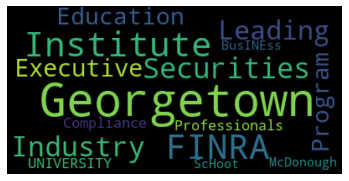

In [27]:
# Import libraries to make a word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wc = WordCloud().generate(" ".join(encoding["words"][0]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# (3) Extract the text from all pages of the CRCP flyer

In [28]:
import glob
import os

In [29]:
# Create list of documents in working directory (current folder)
# that start with "crcp", order it by modification time
doc_images = sorted(glob.glob("crcp*"), key=os.path.getmtime)

In [30]:
doc_images

['crcp_page1.png',
 'crcp_page2.png',
 'crcp_page3.png',
 'crcp_page4.png',
 'crcp_page5.png']

In [31]:
## Loop through each page and extract the text on the page

encodings = []

for each in doc_images:
    image = Image.open(each).convert("RGB")
    pytorch_text_extractor = LayoutLMv3FeatureExtractor()
    encodings.append(pytorch_text_extractor(image, return_tensors="pt")) # returns PyTorch tensors

In [34]:
# SHOW: 0: first page, 1: second page, etc...
encodings[2]["words"]

[['Program',
  'Elements',
  'and',
  'Requirements',
  '‘Week',
  'I:',
  'Foundation',
  '|',
  'July',
  '17-22,',
  '2022',
  'Participants',
  'gather',
  'on',
  'Georgetown',
  'University’s',
  'campus',
  'at',
  'the',
  'McDonough',
  'School',
  '(of',
  'Business',
  'for',
  'intensive',
  'instruction,',
  'discussion',
  'and',
  'case',
  'studies,',
  'gaining',
  'a',
  'strong',
  'Understanding',
  'of',
  'the',
  'foundation',
  'and',
  'application',
  'of',
  'the',
  'financial',
  'services',
  'industry',
  'rules',
  'and',
  'financial',
  'regulations.',
  'Topics',
  'include:',
  '>',
  'Securities',
  'law',
  'and',
  'regulatory',
  'structure»',
  'Books',
  'and',
  'records',
  '>',
  'Supervisory',
  'practices',
  'and',
  'internal',
  'controls»',
  'Communications',
  'withthe',
  'public',
  '‘Week',
  'Il:',
  'Capstone',
  '|',
  'November',
  '13',
  '~',
  '18,',
  '2022',
  'Participants',
  'reconvene',
  'at',
  'Georgetown',
  'Univ

# (4) Process extracted text to analyze

In [35]:
# Combine text from each page into a single string
all_text = [" ".join(each["words"][0]) for each in encodings]

In [36]:
# Create a dataframe to store all_text, each row is a page in the PDF
finra_df = pd.DataFrame({"page":range(1,6),
                         "raw_text":all_text})

In [37]:
finra_df

,page,raw_text
0,1,FINRA Institute at Georgetown = The Securities...
1,2,Become a Certified Regulatory and Compliance P...
2,3,Program Elements and Requirements ‘Week I: Fou...
3,4,"Registration & Fees ‘To register, complete the..."
4,5,About FINRA and Georgetown University’s McDono...


In [ ]:
# 7 Clean text
def process_text(t):
    import re
    
    t = t.lower()
    t = re.sub(r"http\S+", "", t)      # remove links (anything that doesn't have a space after http)
    t = re.sub(r"www.\S+", "", t)      # remove links
    t = re.sub("[^a-z]", " ", t)
    return t

In [ ]:
finra_df

In [ ]:
# Apply process_text function to raw_text column
finra_df["clean_text"] = finra_df["raw_text"].apply(process_text)

In [ ]:
finra_df

In [ ]:
# Import libraries to make a word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

wc = WordCloud(stopwords=STOPWORDS).generate(" ".join(finra_df["clean_text"]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import altair as alt

# 1 Instantiates a vectorizer to vectorize the text (extract features) based on ngram parameters we specify
v = CountVectorizer(stop_words="english",
                    ngram_range=(1, 1))
    
# 2 Vectorizes the text, creates a dataframe with terms and frequencies
dtm = v.fit_transform(finra_df["clean_text"])
    
dtm_df = pd.DataFrame(dtm.toarray(),
                     columns=v.get_feature_names_out())

In [ ]:
dtm_df

In [ ]:
# Transposes the dataframe, make index a column, and renames columns so it is two columns: text, freq
dtm_df = dtm_df.T

In [ ]:
dtm_df

In [ ]:
# Make term a column not the index
dtm_df.reset_index(inplace=True)

In [ ]:
dtm_df

In [ ]:
# Rename the columns
dtm_df.columns = ["term", "page1", "page2", "page3", "page4", "page5"]

In [ ]:
dtm_df

In [ ]:
dtm_df

In [ ]:
# Plot words used on each page
alt.Chart(dtm_df[dtm_df["page3"] > 0]).mark_bar().encode(alt.Y("term", sort="-x"),
                                      x = "page3")

# (5) Define a function to adjust the settings/phrases

In [ ]:
def crcp_words(df, page, phrase_min, phrase_max):
    
    from sklearn.feature_extraction.text import CountVectorizer
    import altair as alt

    # 1 Instantiates a vectorizer to vectorize the text (extract features) based on ngram parameters we specify
    v = CountVectorizer(stop_words="english",
                    ngram_range=(phrase_min, phrase_max))
    
    # 2 Vectorizes the text, creates a dataframe with terms and frequencies
    dtm = v.fit_transform(df["clean_text"])
    
    dtm_df = pd.DataFrame(dtm.toarray(),
                     columns=v.get_feature_names_out())
    
    dtm_df = dtm_df.T
    dtm_df.reset_index(inplace=True)
    dtm_df.columns = ["term", "page1", "page2", "page3", "page4", "page5"]
    
    plot = alt.Chart(dtm_df[dtm_df[f"{page}"] > 1]).mark_bar().encode(alt.Y("term", sort="-x"),
                                      x = f"{page}")
    
    return plot

In [ ]:
dtm_df

In [ ]:
# Use the function
crcp_words(finra_df, page="page4", phrase_min = 3, phrase_max = 3)

 ## Bonus: Extract text from screenshots

In [ ]:
##### Took screenshot of SEC site

In [38]:
# Open the image 
image = Image.open("sec_shot.png").convert("RGB")

# Instantiate a transformers deep learning model 
pytorch_text_extractor = LayoutLMv3FeatureExtractor()

# Use the model to extract text from the image of the first page of the site
encoding = pytorch_text_extractor(image, return_tensors="pt") # returns PyTorch tensors

In [39]:
encoding["words"]

[['EDGAR',
  '-',
  'Search',
  'and',
  'Access',
  'Latest',
  'Filings',
  'Company',
  'Filings',
  'Mutual',
  'Funds',
  'Variable',
  'Insurance',
  'Products',
  'Daily',
  'Filings',
  'by',
  'Type',
  'EDGAR',
  'Full',
  'Text',
  'Search',
  'CIK',
  'Lookup',
  'Confidential',
  'Treatment',
  'Orders',
  'Effectiveness',
  'Notices',
  'Aknt',
  'CReAD',
  'EDGAR—Search',
  'and',
  'Access',
  'You',
  'can',
  'search',
  'information',
  'collected',
  'by',
  'the',
  'SEC',
  'using',
  'a',
  'variety',
  'of',
  'search',
  'tools.',
  'EDGAR',
  'full',
  'text',
  'search',
  '¢',
  'New',
  'versatile',
  'tool',
  'lets',
  'you',
  'search',
  'for',
  'keywords',
  'and',
  'phrases',
  'in',
  'over',
  '20',
  'years',
  'of',
  'EDGAR',
  'filings,',
  'and',
  'filter',
  'by',
  'date,',
  'company,',
  'person,',
  'filing',
  'category,',
  'or',
  'location.',
  'Boolean',
  'and',
  'advanced',
  'searching,',
  'including',
  'addresses',
  'Search

In [ ]:
pd.set_option("display.max_colwidth", None)